In [ ]:
import pandas as pd
import requests

# Your Tiingo API key
api_key = "ADD YOUR API KEY"

ticker = "AAPL"
# Endpoint for daily prices (AAPL as example)
url = f"https://api.tiingo.com/tiingo/daily/{ticker}/prices"

import datetime

end_date = datetime.date.today().strftime("%Y-%m-%d")

params = {
    "token": api_key,
    "startDate": "2022-12-31",
    "endDate": end_date
}

response = requests.get(url, params=params)

data = response.json()
df1 = pd.DataFrame(data)

In [7]:
import requests
import json
from datetime import datetime

# Alpha Vantage News + Sentiment
API_KEY = 'ADD YOUR API KEY'  # Replace with your free key

def fetch_news_sentiment(ticker, time_from, time_to, limit=1000):
    url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={ticker}&time_from={time_from}&time_to={time_to}&limit={limit}&apikey={API_KEY}'
    response = requests.get(url)
    data = response.json()
    if 'feed' in data:
        articles = data['feed']
        df = pd.DataFrame(articles)
        # Key columns: title, summary, time_published (ISO), ticker_sentiment_score, overall_sentiment_score (-1 to 1)
        df['time_published'] = pd.to_datetime(df['time_published'])
        return df[['title', 'summary', 'time_published', 'overall_sentiment_score']]
    else:
        print(f"Error: {data.get('Note', 'Check API key/limits')}")
        return pd.DataFrame()

# Fetch full range (if >1000 articles, it prioritizes recent; split for all)
news_df = fetch_news_sentiment("AAPL", '20200101T0000', '20251001T2359')

# If you need to split by year for more coverage (e.g., loop over years)
all_news = []
years = range(2020, 2026)
for year in years:
    time_from = f'{year}0101T0000'
    time_to = f'{year}1231T2359'
    yearly_df = fetch_news_sentiment("AAPL", time_from, time_to)
    all_news.append(yearly_df)
news_df = pd.concat(all_news, ignore_index=True).drop_duplicates(subset=['title'])


Error: Check API key/limits
Error: Check API key/limits


In [8]:
news_df

,title,summary,time_published,overall_sentiment_score
0,"Apple, AMC, Meta, And How Elon Musk Is Reactin...",Benzinga examined the prospects for many inves...,2022-12-31 19:03:10,-0.079733
1,Bulls In A Bear Market: These 10 Stocks Clocke...,2022 would go down as one of the worst years f...,2022-12-31 16:11:14,0.064077
2,Where Will Unity Software Stock Be in 3 Years?,The game-engine developer still has a lot to p...,2022-12-31 15:45:00,0.202065
3,3 Unstoppable Growth Stocks to Buy After a Sto...,These companies have grown by triple-digit per...,2022-12-31 14:00:00,0.152163
4,"Even in an Advertising Slowdown, These 3 Stock...","Ad sales growth will slow in 2023, but these s...",2022-12-31 12:00:00,0.151938
...,...,...,...,...
2724,Why Is Alibaba Stock Falling Thursday? - Aliba...,ByteDance launched Seed-OSS-36B AI to rival Al...,2025-08-21 12:38:54,0.019376
2725,"How To Trade SPY, Top Tech Stocks Using Techni...",Today's economic calendar begins with a packed...,2025-08-21 12:32:15,-0.034746
2726,Global OTT Platform Market to Reach USD 595 Bi...,"NEW DELHI, Aug. 21, 2025 /PRNewswire/ -- The G...",2025-08-21 10:46:00,0.247846
2727,Highlights From Berkshire Hathaway Earnings: 3...,Berkshire reported earnings and its stock hold...,2025-08-21 10:41:00,0.080981


In [9]:
df1["date"] = pd.to_datetime(df1["date"])
df1["date"] = df1["date"].dt.strftime("%Y-%m-%d")

In [10]:
df_close = df1[["date", "close"]]
df_open = df1[["date", "open"]]

In [11]:
news_df["date"] = pd.to_datetime(news_df["time_published"])
news_df["date"] = news_df["date"].dt.strftime("%Y-%m-%d")

In [12]:
news_df = news_df[["date", "overall_sentiment_score"]]

In [13]:
combined_df_close = df_close.merge(news_df, on='date', how='left')

In [14]:
combined_df_close['overall_sentiment_score'] = combined_df_close['overall_sentiment_score'].fillna(0)

In [15]:
combined_df_open = df_open.merge(news_df, on='date', how='left')

In [16]:
combined_df_open['overall_sentiment_score'] = combined_df_open['overall_sentiment_score'].fillna(0)

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

features = ['open', 'overall_sentiment_score']
df_features_open = combined_df_open[features].copy()

# Create lagged prices (e.g., 60 days)
for i in range(1, 61):
    df_features_open[f'open_lag_{i}'] = df_features_open['open'].shift(i)

# Drop NaN from lags
df_features_open = df_features_open.dropna()

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_features_open)

# Create sequences for LSTM
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 0])  # Predict next close    
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
X_train_open, X_test_open, y_train_open, y_test_open = train_test_split(X, y, test_size=0.2, shuffle=False)

In [18]:
features = ['close', 'overall_sentiment_score']
df_features_close = combined_df_close[features].copy()

# Create lagged prices (e.g., 60 days)
for i in range(1, 61):
    df_features_close[f'close_lag_{i}'] = df_features_close['close'].shift(i)

# Drop NaN from lags
df_features_close = df_features_close.dropna()

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_features_close)

# Create sequences for LSTM
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 0])  # Predict next close    
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
X_train_close, X_test_close, y_train_close, y_test_close = train_test_split(X, y, test_size=0.2, shuffle=False)

In [27]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

model_close = Sequential()
model_close.add(LSTM(50, return_sequences=True, input_shape=(X_train_close.shape[1], X_train_close.shape[2]), activation='relu'))  # Relu for hidden units
model_close.add(Dropout(0.2))
model_close.add(LSTM(50, return_sequences=False, activation='relu'))  # Relu for hidden units
model_close.add(Dropout(0.2))
model_close.add(Dense(25, activation='relu'))  # Relu for non-linearity
model_close.add(Dense(1, activation='linear'))  # Linear for regression output

model_close.compile(optimizer='adam', loss='mean_squared_error')

Matplotlib is building the font cache; this may take a moment.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model_close.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        22,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,101 (172.27 KB)

 Trainable params: 44,101 (172.27 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model_close.fit(X_train_close, y_train_close)

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0352


In [30]:
y_test_close_predict = model_close.predict(X_test_close)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [31]:
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(y_test_close_predict, y_test_close))

0.1410616289074384

In [32]:
y_train_close_predict = model_close.predict(X_train_close)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [33]:
math.sqrt(mean_squared_error(y_train_close_predict, y_train_close))

0.11071130793784101

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


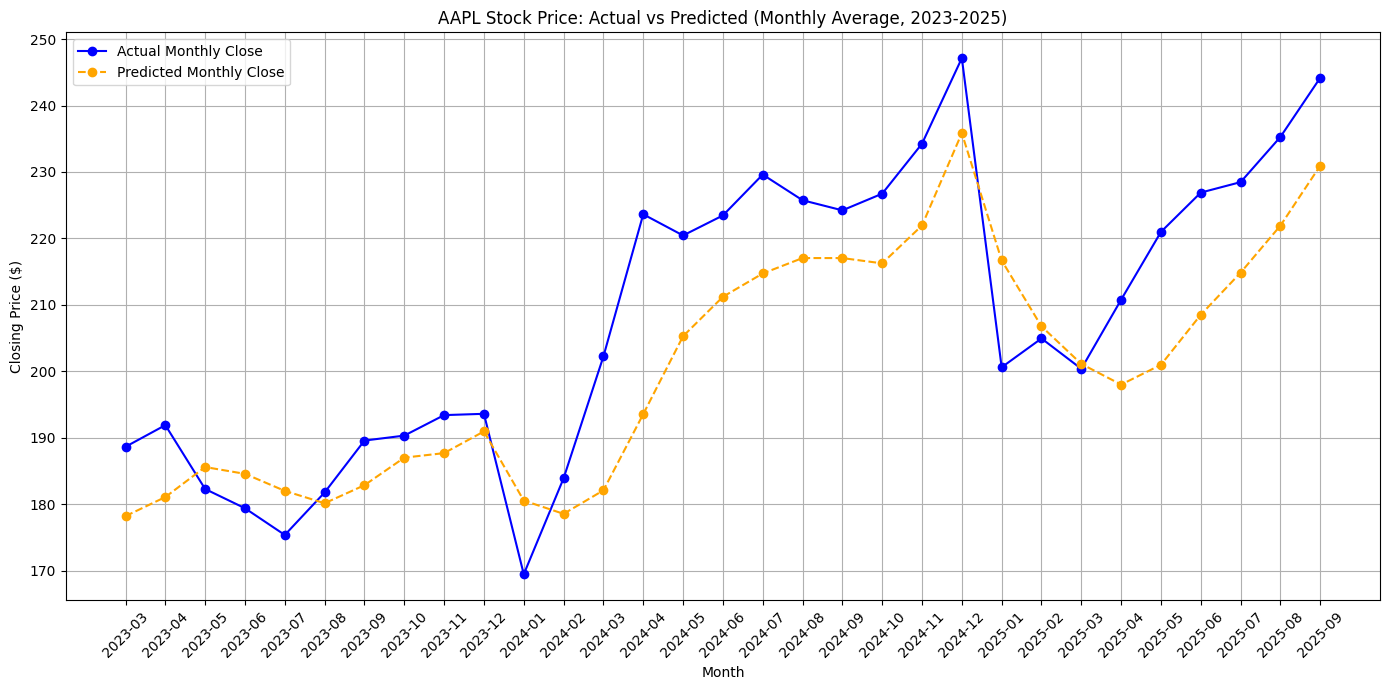

In [34]:
import matplotlib.pyplot as plt

y_train_actual = y_train_close  # Actual training closes
y_test_actual = y_test_close    # Actual test closes

# Get predictions (assuming model_close is your trained model)
y_train_predict = model_close.predict(X_train_close)  # Predicted training closes
y_test_predict = model_close.predict(X_test_close)    # Predicted test closes

# Reshape for inverse_transform (pad with zeros for other features)
y_train_actual_reshaped = np.column_stack((y_train_actual, np.zeros((len(y_train_actual), X_train_close.shape[2] - 1))))
y_test_actual_reshaped = np.column_stack((y_test_actual, np.zeros((len(y_test_actual), X_test_close.shape[2] - 1))))
y_train_predict_reshaped = np.column_stack((y_train_predict.flatten(), np.zeros((len(y_train_predict), X_train_close.shape[2] - 1))))
y_test_predict_reshaped = np.column_stack((y_test_predict.flatten(), np.zeros((len(y_test_predict), X_test_close.shape[2] - 1))))

# Inverse transform to get original prices
y_train_actual_original = scaler.inverse_transform(y_train_actual_reshaped)[:, 0]
y_test_actual_original = scaler.inverse_transform(y_test_actual_reshaped)[:, 0]
y_train_predict_original = scaler.inverse_transform(y_train_predict_reshaped)[:, 0]
y_test_predict_original = scaler.inverse_transform(y_test_predict_reshaped)[:, 0]

# Get corresponding dates from combined_df_close (adjust based on window size, e.g., 60)
train_dates = pd.to_datetime(combined_df_close['date'].iloc[60:60 + len(y_train_close)])  # Ensure datetime
test_dates = pd.to_datetime(combined_df_close['date'].iloc[60 + len(y_train_close):60 + len(y_train_close) + len(y_test_close)])  # Ensure datetime

# Create DataFrames for actual and predicted values with dates
train_df = pd.DataFrame({'date': train_dates, 'actual': y_train_actual_original, 'predict': y_train_predict_original})
test_df = pd.DataFrame({'date': test_dates, 'actual': y_test_actual_original, 'predict': y_test_predict_original})
full_df = pd.concat([train_df, test_df])

# Verify and convert 'date' to datetime if needed
if not pd.api.types.is_datetime64_any_dtype(full_df['date']):
    full_df['date'] = pd.to_datetime(full_df['date'])

# Aggregate by month (monthly average)
monthly_data = full_df.groupby(full_df['date'].dt.to_period('M')).mean()[['actual', 'predict']]

# Create month-wise x-axis labels and positions
months = monthly_data.index.astype(str)  # e.g., '2020-01', '2020-02'
x_positions = range(len(months))

# Plotting monthly data
plt.figure(figsize=(14, 7))
plt.plot(x_positions, monthly_data['actual'], label='Actual Monthly Close', color='blue', marker='o')
plt.plot(x_positions, monthly_data['predict'], label='Predicted Monthly Close', color='orange', linestyle='--', marker='o')
plt.xticks(x_positions, months, rotation=45)
plt.title(f'AAPL Stock Price: Actual vs Predicted (Monthly Average, {train_dates.min().year}-{test_dates.max().year})')
plt.xlabel('Month')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━

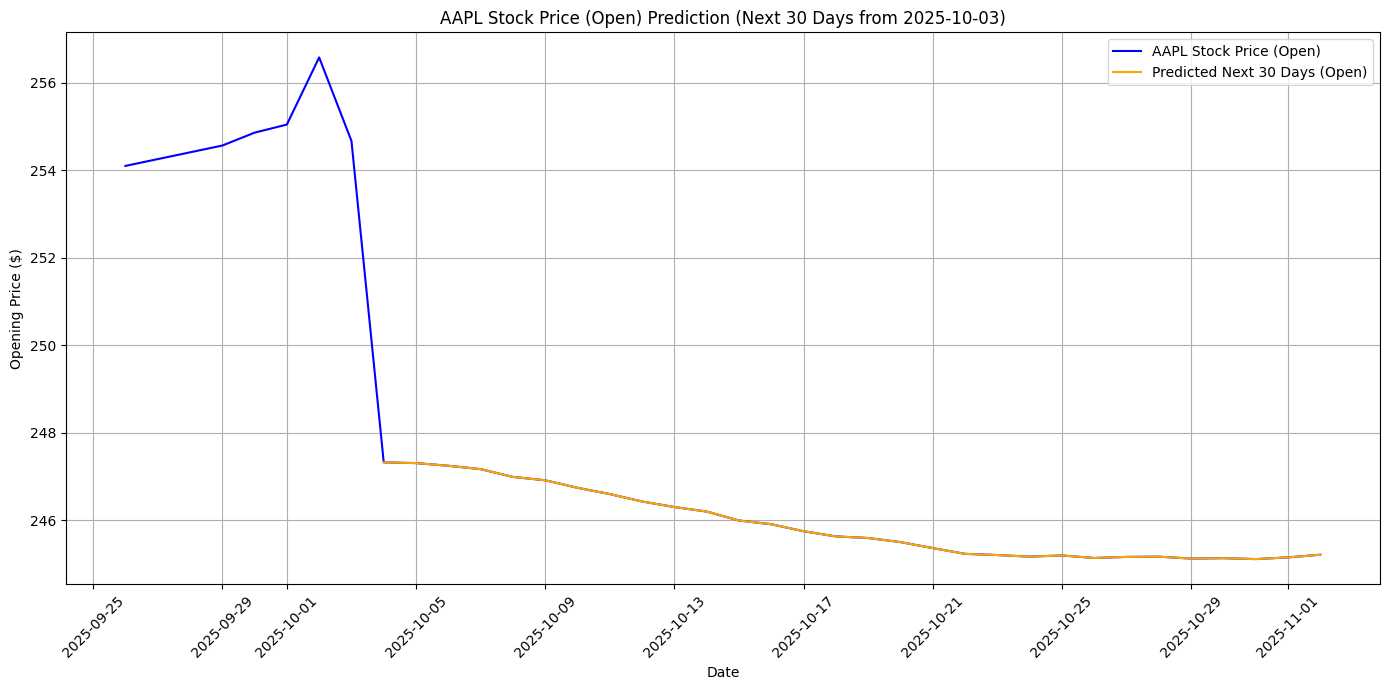

In [ ]:
last_sequence = X_test_close[-1]  # Shape: (timesteps, features)
future_predictions = []

# Iterate to predict the next 30 days
current_sequence = last_sequence.copy()
for _ in range(30):
    # Reshape for prediction (1, timesteps, features)
    next_pred = model_close.predict(current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1]))
    future_predictions.append(next_pred[0, 0])  # Extract the scalar prediction
    # Update the sequence: roll and replace the last value with the prediction
    current_sequence = np.roll(current_sequence, -1, axis=0)
    current_sequence[-1, 0] = next_pred[0, 0]  # Assume 'close' is the first feature

# Reshape predictions for inverse transform (pad with zeros for other features)
future_predictions_reshaped = np.column_stack((future_predictions, np.zeros((len(future_predictions), X_test_close.shape[2] - 1))))

# Inverse transform to get original prices
future_predictions_original = scaler.inverse_transform(future_predictions_reshaped)[:, 0]

# Generate future dates (starting from the day after the last date, ensure naive datetime)
last_date = pd.to_datetime(combined_df_close['date'].iloc[-1]).replace(tzinfo=None)  # Remove timezone if any
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Get historical data for context (last 60 days)
last_60_dates = pd.to_datetime(combined_df_close['date'].iloc[-60:])
last_60_closes = combined_df_close['close'].iloc[-60:]

# Debugging: Check date transition
print("Last historical date:", last_60_dates.iloc[-1])
print("First predicted date:", future_dates[0])

# Convert DatetimeIndex to Series for concatenation
last_60_dates_series = pd.Series(last_60_dates)
future_dates_series = pd.Series(future_dates)

# Combine dates and values
all_dates = pd.concat([last_60_dates_series, future_dates_series]).reset_index(drop=True)
all_values = np.concatenate([last_60_closes, future_predictions_original])

# Plotting with continuous x-axis
plt.figure(figsize=(14, 7))
plt.plot(all_dates, all_values, label='AAPL Stock Price', color='blue')


# Highlight predictions with a different style
plt.plot(all_dates.iloc[len(last_60_closes):], future_predictions_original, label='Predicted Next 30 Days', color='orange')

plt.title(f'AAPL Stock Price Prediction (Next 30 Days from {last_date.date()})')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
model_open = Sequential()
model_open.add(LSTM(50, return_sequences=True, input_shape=(X_train_close.shape[1], X_train_close.shape[2]), activation='relu'))  # Relu for hidden units
model_open.add(Dropout(0.2))
model_open.add(LSTM(50, return_sequences=False, activation='relu'))  # Relu for hidden units
model_open.add(Dropout(0.2))
model_open.add(Dense(25, activation='relu'))  # Relu for non-linearity
model_open.add(Dense(1, activation='linear'))  # Linear for regression output

model_open.compile(optimizer='adam', loss='mean_squared_error')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
model_open.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        22,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,101 (172.27 KB)

 Trainable params: 44,101 (172.27 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model_open.fit(X_train_open, y_train_open)

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0635


In [39]:
y_test_open_predict = model_open.predict(X_test_open)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [41]:
math.sqrt(mean_squared_error(y_test_open_predict, y_test_close))

0.1434004757872901

In [42]:
y_train_open_predict = model_open.predict(X_train_open)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


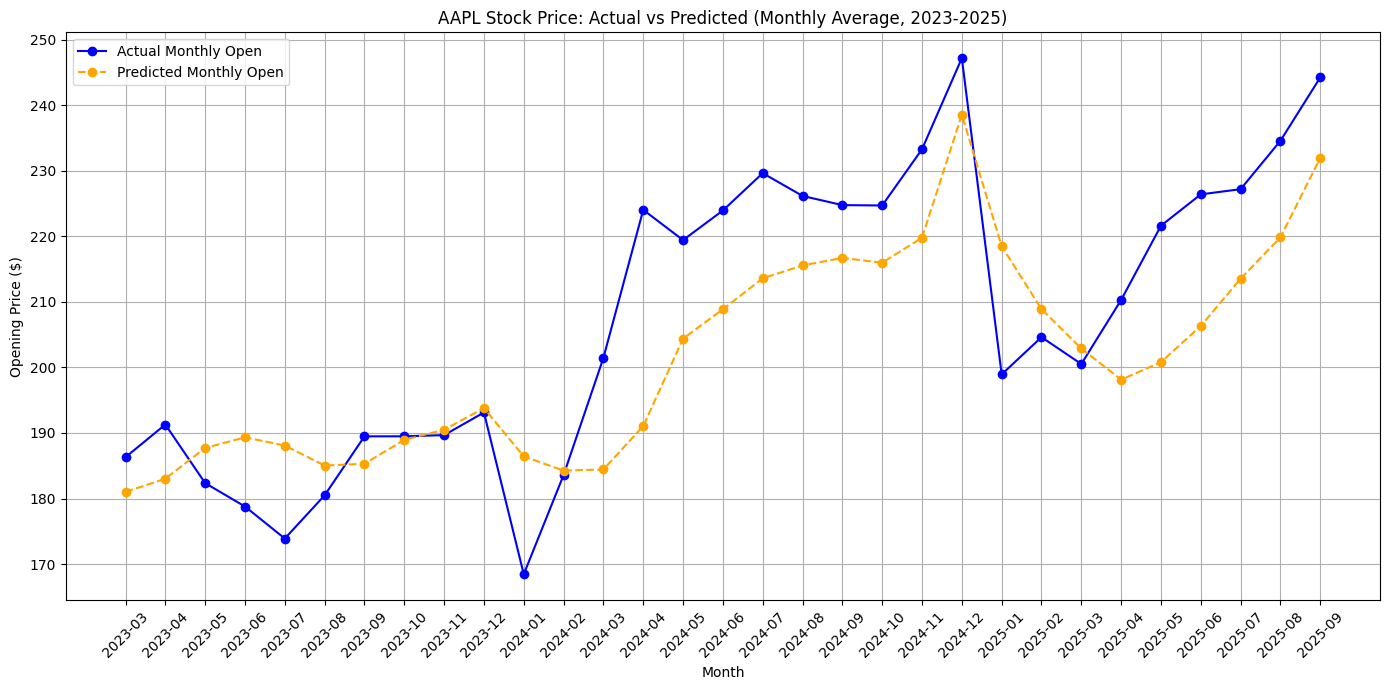

In [45]:
import matplotlib.pyplot as plt

y_train_actual = y_train_open  # Actual training opens
y_test_actual = y_test_open    # Actual test opens

# Get predictions (assuming model_open is your trained model)
y_train_predict = model_open.predict(X_train_open)  # Predicted training opens
y_test_predict = model_open.predict(X_test_open)    # Predicted test opens

# Reshape for inverse_transform (pad with zeros for other features)
y_train_actual_reshaped = np.column_stack((y_train_actual, np.zeros((len(y_train_actual), X_train_open.shape[2] - 1))))
y_test_actual_reshaped = np.column_stack((y_test_actual, np.zeros((len(y_test_actual), X_train_open.shape[2] - 1))))
y_train_predict_reshaped = np.column_stack((y_train_predict.flatten(), np.zeros((len(y_train_predict), X_train_open.shape[2] - 1))))
y_test_predict_reshaped = np.column_stack((y_test_predict.flatten(), np.zeros((len(y_test_predict), X_test_open.shape[2] - 1))))

# Inverse transform to get original prices
y_train_actual_original = scaler.inverse_transform(y_train_actual_reshaped)[:, 0]
y_test_actual_original = scaler.inverse_transform(y_test_actual_reshaped)[:, 0]
y_train_predict_original = scaler.inverse_transform(y_train_predict_reshaped)[:, 0]
y_test_predict_original = scaler.inverse_transform(y_test_predict_reshaped)[:, 0]

# Get corresponding dates from combined_df_open (adjust based on window size, e.g., 60)
train_dates = pd.to_datetime(combined_df_open['date'].iloc[60:60 + len(y_train_open)])  # Ensure datetime
test_dates = pd.to_datetime(combined_df_open['date'].iloc[60 + len(y_train_open):60 + len(y_train_open) + len(y_test_open)])  # Ensure datetime

# Create DataFrames for actual and predicted values with dates
train_df = pd.DataFrame({'date': train_dates, 'actual': y_train_actual_original, 'predict': y_train_predict_original})
test_df = pd.DataFrame({'date': test_dates, 'actual': y_test_actual_original, 'predict': y_test_predict_original})
full_df = pd.concat([train_df, test_df])

# Verify and convert 'date' to datetime if needed
if not pd.api.types.is_datetime64_any_dtype(full_df['date']):
    full_df['date'] = pd.to_datetime(full_df['date'])

# Aggregate by month (monthly average)
monthly_data = full_df.groupby(full_df['date'].dt.to_period('M')).mean()[['actual', 'predict']]

# Create month-wise x-axis labels and positions
months = monthly_data.index.astype(str)  # e.g., '2020-01', '2020-02'
x_positions = range(len(months))

# Plotting monthly data
plt.figure(figsize=(14, 7))
plt.plot(x_positions, monthly_data['actual'], label='Actual Monthly Open', color='blue', marker='o')
plt.plot(x_positions, monthly_data['predict'], label='Predicted Monthly Open', color='orange', linestyle='--', marker='o')
plt.xticks(x_positions, months, rotation=45)
plt.title(f'AAPL Stock Price: Actual vs Predicted (Monthly Average, {train_dates.min().year}-{test_dates.max().year})')
plt.xlabel('Month')
plt.ylabel('Opening Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

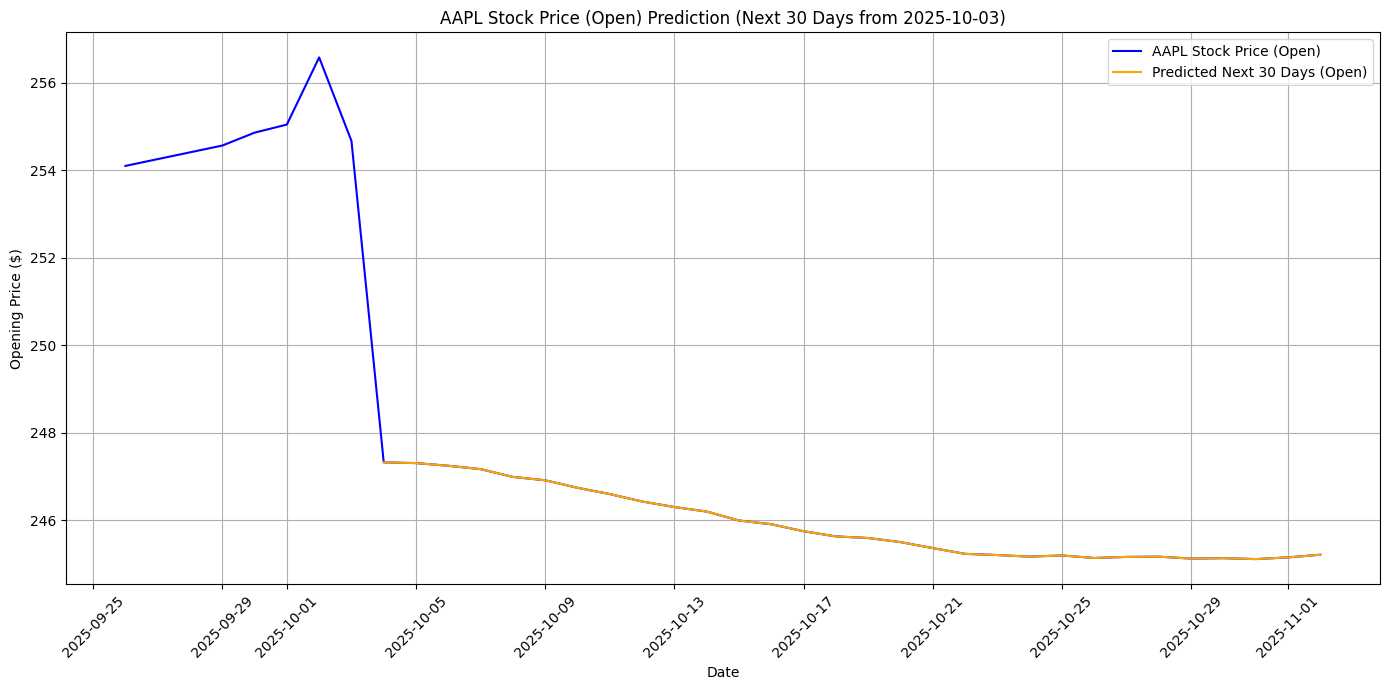

In [47]:
last_sequence = X_test_open[-1]  # Shape: (timesteps, features)
future_predictions = []

# Iterate to predict the next 30 days
current_sequence = last_sequence.copy()
for _ in range(30):
    # Reshape for prediction (1, timesteps, features)
    next_pred = model_open.predict(current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1]))
    future_predictions.append(next_pred[0, 0])  # Extract the scalar prediction
    # Update the sequence: roll and replace the last value with the prediction
    current_sequence = np.roll(current_sequence, -1, axis=0)
    current_sequence[-1, 0] = next_pred[0, 0]  # Assume 'open' is the first feature

# Reshape predictions for inverse transform (pad with zeros for other features)
future_predictions_reshaped = np.column_stack((future_predictions, np.zeros((len(future_predictions), X_test_open.shape[2] - 1))))

# Inverse transform to get original prices
future_predictions_original = scaler.inverse_transform(future_predictions_reshaped)[:, 0]

# Generate future dates (starting from the day after the last date, ensure naive datetime)
last_date = pd.to_datetime(combined_df_open['date'].iloc[-1]).replace(tzinfo=None)  # Remove timezone if any
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Get historical data for context (last 60 days)
last_60_dates = pd.to_datetime(combined_df_open['date'].iloc[-60:])
last_60_opens = combined_df_open['open'].iloc[-60:]

# Debugging: Check date transition
print("Last historical date:", last_60_dates.iloc[-1])
print("First predicted date:", future_dates[0])

# Convert DatetimeIndex to Series for concatenation
last_60_dates_series = pd.Series(last_60_dates)
future_dates_series = pd.Series(future_dates)

# Combine dates and values
all_dates = pd.concat([last_60_dates_series, future_dates_series]).reset_index(drop=True)
all_values = np.concatenate([last_60_opens, future_predictions_original])

# Plotting with continuous x-axis
plt.figure(figsize=(14, 7))
plt.plot(all_dates, all_values, label='AAPL Stock Price (Open)', color='blue')

# Highlight predictions with a different style
plt.plot(all_dates.iloc[len(last_60_opens):], future_predictions_original, label='Predicted Next 30 Days (Open)', color='orange')

plt.title(f'AAPL Stock Price (Open) Prediction (Next 30 Days from {last_date.date()})')
plt.xlabel('Date')
plt.ylabel('Opening Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━

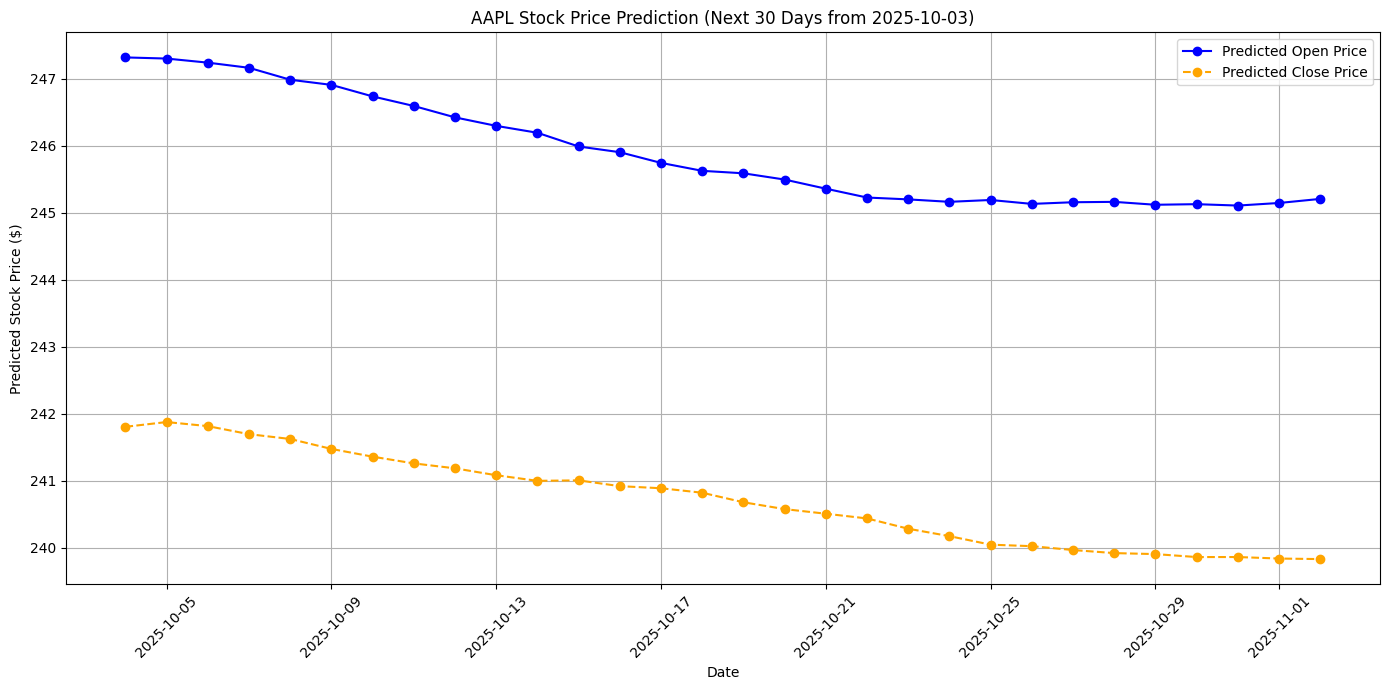

In [49]:
import matplotlib.pyplot as plt

# --- PREDICT FUTURE OPEN PRICES ---

last_sequence_open = X_test_open[-1]
future_predictions_open = []

current_sequence_open = last_sequence_open.copy()
for _ in range(30):
    next_pred_open = model_open.predict(current_sequence_open.reshape(1, current_sequence_open.shape[0], current_sequence_open.shape[1]))
    future_predictions_open.append(next_pred_open[0, 0])
    current_sequence_open = np.roll(current_sequence_open, -1, axis=0)
    current_sequence_open[-1, 0] = next_pred_open[0, 0]

# Inverse transform (pad zeros for other features)
future_predictions_open_reshaped = np.column_stack((future_predictions_open, np.zeros((len(future_predictions_open), X_test_open.shape[2] - 1))))
future_predictions_open_original = scaler.inverse_transform(future_predictions_open_reshaped)[:, 0]


# --- PREDICT FUTURE CLOSE PRICES ---

last_sequence_close = X_test_close[-1]
future_predictions_close = []

current_sequence_close = last_sequence_close.copy()
for _ in range(30):
    next_pred_close = model_close.predict(current_sequence_close.reshape(1, current_sequence_close.shape[0], current_sequence_close.shape[1]))
    future_predictions_close.append(next_pred_close[0, 0])
    current_sequence_close = np.roll(current_sequence_close, -1, axis=0)
    current_sequence_close[-1, 0] = next_pred_close[0, 0]

# Inverse transform (pad zeros for other features)
future_predictions_close_reshaped = np.column_stack((future_predictions_close, np.zeros((len(future_predictions_close), X_test_close.shape[2] - 1))))
future_predictions_close_original = scaler.inverse_transform(future_predictions_close_reshaped)[:, 0]


# --- GENERATE FUTURE DATES ---
last_date = pd.to_datetime(combined_df_open['date'].iloc[-1]).replace(tzinfo=None)
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')


# --- PLOT ONLY PREDICTED VALUES ---
plt.figure(figsize=(14, 7))

plt.plot(future_dates, future_predictions_open_original, label='Predicted Open Price', color='blue', marker='o')
plt.plot(future_dates, future_predictions_close_original, label='Predicted Close Price', color='orange', marker='o', linestyle='--')

plt.title(f'AAPL Stock Price Prediction (Next 30 Days from {last_date.date()})')
plt.xlabel('Date')
plt.ylabel('Predicted Stock Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
